# Introduction

Cities across the United States are capitalizing on big data. Predictive policing is becoming a prominent tool for public safety in many cities. In Boston, an algorithm helps determine “problem properties” where the city can target interventions. In Chicago, they are protecting citizens by predicting which landlords are not complying with city ordinances. In New York, the Fire Department sends inspectors to the highest risk buildings so they can prevent deadly fires from breaking out.

According to the CDC, more than 48 million Americans per year become sick from food, and an estimated 75% of the outbreaks came from food prepared by caterers, delis, and restaurants. In most cities, health inspections are generally random, which can increase time spent on spot checks at clean restaurants that have been following the rules closely — and missed opportunities to improve health and hygiene at places with more pressing food safety issues.

The goal for this project is to leverage public citizen generated data from social media to narrow the search for critical health and safety violations in New York City. As the City of New York manages  an open data portal, everyone can access historical hygiene inspections and violation records. By combine these two data source this project aims to determine which words, phrases, ratings, and patterns among restaurants lead to critical health and safety violations. This model can assist city health inspectors do their job better by prioritizing the kitchens most likely to be in violation of code.

The New York Health Department inspects the approximately 27,000 restaurants within the city to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

### Imports

In [463]:
from IPython import display
from bs4 import BeautifulSoup as bs
import requests
import json
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
import time

# misc
import glob, os
import ast

call_apis = False
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_columns',50)
pd.options.display.float_format = '{:.2f}'.format

from sklearn.preprocessing import OneHotEncoder


### Can you predict if a restaurant has received a C Grade?
### Can you predict a restaurants yelp rating based on its review text?
### Can you recommend a similar restaurant nearby with a better health score for restaurants searched for with a C

# Obtain

This project requires data pulled from two different sources, the City of New York and Yelp. To obtain the data we will call the API keys.

 > The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.
Records are also included for each restaurant that has applied for a permit but has not yet been inspected and for inspections resulting in no violations. Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection. Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.
Because this dataset is compiled from several large administrative data systems, it contains some illogical values that could be a result of data entry or transfer errors. Data may also be missing.
This dataset and the information on the Health Department’s Restaurant Grading website come from the same data source. The Health Department’s Restaurant Grading website is here:
http://www1.nyc.gov/site/doh/services/restaurant-grades.page

> Why does the Health Department inspect restaurants?
The Health Department inspects the approximately 27,000 restaurants in New York City to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

> Since 2010, New York City has required restaurants to post letter grades that correspond to scores received from sanitary inspections. An inspection score of 0 to 13 is an A, 14 to 27 points is a B, and 28 or more points is a C. Grade cards must be posted where they can easily be seen by people passing by.

> The New York City Health Department inspects all food service establishments to make sure they meet Health Code requirements, which helps prevent
foodborne illness. How often a restaurant is inspected depends on its inspection score. Restaurants that receive a low score on the initial or first inspection
in the inspection cycle are inspected less often than those that receive a high score.

> The points for a particular violation depend on the health risk it poses to the public. Violations fall into three categories:
>* A public health hazard, such as failing to keep food at the right temperature, triggers a minimum of 7 points. If the violation can’t be corrected before the inspection ends, the Health Department may close the restaurant until it’s fixed.
>* A critical violation, for example, serving raw food such as a salad without properly washing it first, carries a minimum of 5 points.
>* A general violation, such as not properly sanitizing
cooking utensils, receives at least 2 points.

>Inspectors assign additional points to reflect the extent of the
violation. A violation’s condition level can range from 1 (least
extensive) to 5 (most extensive). For example, the presence of
one contaminated food item is a condition level 1 violation,
generating 7 points. Four or more contaminated food items
is a condition level 4 violation, resulting in 10 points. 

> How are restaurants graded?
Violations found during inspections carry point values, and a restaurant’s score corresponds to a letter grade. The point/grade cut-offs are the same as for mobile food vending letter grading, with fewer points corresponding to a better grade:

>* "A" grade: 0 to 13 points for sanitary violations
>* "B" grade: 14 to 27 points for sanitary violations
>* "C" grade: 28 or more points for sanitary violations


The City of New York inspects all restaurants cyclically. And if a business does not pass it's initial inspection for the cycle, it will be re-inspected in 3-5 months.

## Obtaining Restaurant Inspection Results from NYC Open Data Portal

The dataset can be obtained here

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

The dataset was downloaded and saved to this repository. Let's load it in and explore its contents.

Detailed descriptions about each column can be found in the Restaurant Inspection Data Dictionary.

In [20]:
doh_df = pd.read_csv('data/nyc_open_data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
doh_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.00,2129569488,Chicken,01/28/2019,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.77,-73.99,104.00,3.00,13300.00,1025235.00,1010430004.00,MN15
1,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.00,7187087600,American,09/23/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.89,-73.91,208.00,11.00,29500.00,2084186.00,2057960167.00,BX29
2,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
4,40538234,"DUNKIN',' BASKIN ROBBINS",Queens,9925,HORACE HARDING EXPRESSWAY,11368.00,7182719222,Donuts,07/29/2021,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or sto...",Critical,10,A,07/29/2021,03/24/2022,Cycle Inspection / Initial Inspection,40.74,-73.86,404.00,21.00,43702.00,4047915.00,4019480019.00,QN25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186222,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,nan,2126787701,Hamburgers,03/01/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,3,A,03/01/2019,03/24/2022,Cycle Inspection / Initial Inspection,0.00,0.00,nan,nan,nan,nan,1.00,NaN
186223,50032876,TANNER SMITH'S,Manhattan,204,WEST 55 STREET,10019.00,9175172283,American,06/07/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premise...,Not Critical,12,A,06/07/2019,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,13700.00,1024857.00,1010260037.00,MN17
186224,50003842,T- 45,Manhattan,135,WEST 45 STREET,10036.00,6466403775,American,07/26/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,49,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,11900.00,1089796.00,1009980015.00,MN17
186225,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472.00,7184508363,Spanish,07/20/2018,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizing solution.,Critical,12,A,07/20/2018,03/24/2022,Cycle Inspection / Initial Inspection,40.83,-73.88,209.00,18.00,5001.00,2023533.00,2037160036.00,BX55


The dataset contains 186,227 inspection results. However, when an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. So let's check how many individual restaurants are in the dataset.

### Understanding NYC DOHMH Data

In [21]:
# How many unique restaurants are in this dataset?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants in the dataset. ')

There are 19792 unique restaurants in the dataset. 


In [27]:
# Get more information about the dataset contents
doh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174725 entries, 0 to 186226
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  174725 non-null  int64  
 1   DBA                    174698 non-null  object 
 2   BORO                   174725 non-null  object 
 3   BUILDING               174320 non-null  object 
 4   STREET                 174725 non-null  object 
 5   ZIPCODE                171831 non-null  float64
 6   PHONE                  174712 non-null  object 
 7   CUISINE DESCRIPTION    174724 non-null  object 
 8   INSPECTION DATE        174725 non-null  object 
 9   ACTION                 174725 non-null  object 
 10  VIOLATION CODE         173929 non-null  object 
 11  VIOLATION DESCRIPTION  174361 non-null  object 
 12  CRITICAL FLAG          174725 non-null  object 
 13  SCORE                  174725 non-null  int64  
 14  GRADE                  61921 non-nul

In [22]:
doh_df['ZIPCODE'].astype(str)

0         10019.0
1         10463.0
2         10022.0
3         10022.0
4         11368.0
           ...   
186222        nan
186223    10019.0
186224    10036.0
186225    10472.0
186226    10461.0
Name: ZIPCODE, Length: 186227, dtype: object

In [28]:
doh_df['Community Board'].astype(str)

0         104.0
1         208.0
2         105.0
4         404.0
5         101.0
          ...  
186221      nan
186223    105.0
186224    105.0
186225    209.0
186226    210.0
Name: Community Board, Length: 174725, dtype: object

In [23]:
doh_df['Council District'].astype(str)

0          3.0
1         11.0
2          4.0
3          4.0
4         21.0
          ... 
186222     nan
186223     4.0
186224     4.0
186225    18.0
186226    13.0
Name: Council District, Length: 186227, dtype: object

In [26]:
doh_df['Census Tract'].astype(str)

0         13300.0
1         29500.0
2         11202.0
4         43702.0
5          2100.0
           ...   
186221        nan
186223    13700.0
186224    11900.0
186225     5001.0
186226    30000.0
Name: Census Tract, Length: 174725, dtype: object

Every row has a restaurant ID, address, date, and score. Let's ensure there aren't any duplicated rows.

In [29]:
print(f'There are {doh_df.duplicated(keep=False).sum()} duplicated rows. ')

There are 0 duplicated rows. 


In [24]:
# Let's drop these duplucated rows
doh_df.drop_duplicates(keep='first',inplace=True)

In [30]:
# Confirming duplicates have been removed
doh_df.shape

(174725, 26)

Since this project will be leveraging data publicly generated from social media a lookup value will be needed to call the API and join the tables. The Yelp API has an endpoint for Phone Search. This will allow us to pull Yelp business data for each restaurant by proivinging a telephone number. More infomration can be found in the [documentation here.](https://www.yelp.com/developers/documentation/v3/business_search_phone)

In [31]:
# Checking that every restaunt has a phone number
missing_num = doh_df['PHONE'].isna().sum()
print(f'There are {missing_num} restaunts missing a telephone number.')

There are 13 restaunts missing a telephone number.


In [32]:
# Since only 13 numbers are missing, these rows can be dropped
doh_df.dropna(subset=['PHONE'],inplace=True)

In [33]:
# Confirming records were dropped
doh_df['PHONE'].isna().sum()

0

In [34]:
# How many unique restaurants are remaining?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants remaining in the dataset. ')

There are 19790 unique restaurants remaining in the dataset. 


Let's explore the date range for this dataset.

In [35]:
doh_df['INSPECTION DATE'] =  pd.to_datetime(doh_df['INSPECTION DATE'])
begin_date = doh_df['INSPECTION DATE'].min()
end_date = doh_df['INSPECTION DATE'].max()
print(f'The data ranges from {begin_date} to {end_date}')

The data ranges from 2009-05-16 00:00:00 to 2022-03-23 00:00:00


Inspections in this dataset range from May 2009 up to March 2022.

### Target Variable -- NYCDOH Inspection Grades

Health code violations found during an inspections carries a point value, and a restaurant’s score corresponds to a letter grade. A lower point score, leads to a better letter grade:

* "A" grade: 0 to 13 points for sanitary violations
* "B" grade: 14 to 27 points for sanitary violations
* "C" grade: 28 or more points for sanitary violations

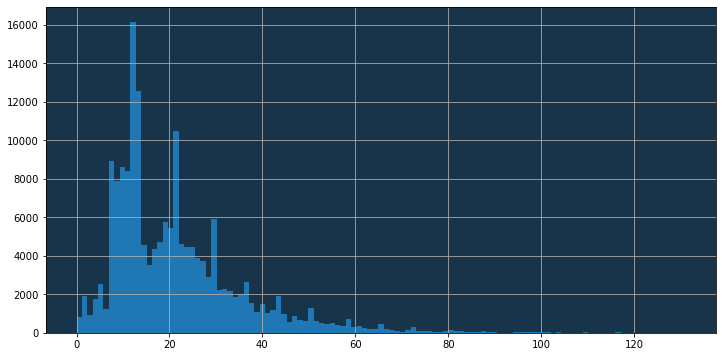

In [162]:
# Let see what the score distribution is
doh_df['SCORE'].hist(bins=113, figsize=(12,6));

In [37]:
doh_df['SCORE'].describe()

count   174712.00
mean        21.36
std         14.36
min          0.00
25%         12.00
50%         18.00
75%         27.00
max        131.00
Name: SCORE, dtype: float64

In [38]:
doh_graded = doh_df.copy()

In [39]:
doh_graded.drop(columns=['INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG','GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],inplace=True)

In [40]:
doh_graded['A'] = (doh_graded['SCORE'] < 14).astype(int)
doh_graded['B'] = (doh_graded['SCORE'] > 13).astype(int) & (doh_df['SCORE'] < 28).astype(int)
doh_graded['C'] = (doh_graded['SCORE'] > 27).astype(int)

In [41]:
doh_grouped = doh_graded.groupby(by=['CAMIS', 'DBA','CUISINE DESCRIPTION',
                                     'BORO', 'BUILDING',
                                     'STREET', 'ZIPCODE', 'PHONE', 'Latitude',
                                     'Longitude', 'Community Board',
                                     'Council District','Census Tract'],dropna=False)['A','B','C'].sum()

In [42]:
(doh_grouped['B'] > 0).sum()

9977

Of the 19,790 unique restaurants, 9,977 failed an initial cycle inspection at least once.

In [43]:
(doh_grouped['C'] > 0).sum()

5648

Of the 19,790 unique restaurants, 5,648 severly failed an initial cycle inspection at least once and are at risk of being closed by the DOHMH.

In [44]:
# Creating the Target Variable 'Severe' for Restaurants that have scored over 28 points in an initial inspection.
doh_grouped['Severe'] = (doh_grouped['C'] > 0).astype(int)

In [101]:
nyc_df = doh_grouped.reset_index()
nyc_df.drop(['A','B','C'],axis=1, inplace=True)
nyc_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe
0,30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,Bronx,1007,MORRIS PARK AVENUE,10462.00,7188924968,40.85,-73.86,211.00,13.00,25200.00,0
1,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,7182875005,40.66,-73.96,309.00,40.00,32700.00,0
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,Manhattan,351,WEST 57 STREET,10019.00,2122452912,40.77,-73.98,104.00,3.00,13900.00,0
3,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,7183723031,40.58,-73.98,313.00,47.00,34800.00,0
4,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,7184443838,40.62,-73.91,318.00,46.00,70000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19785,50115169,Sobak,Korean,Manhattan,51,CANAL STREET,10002.00,9294018597,40.71,-73.99,103.00,1.00,1600.00,0
19786,50116155,SEPTEMBER,Coffee/Tea,Brooklyn,83,SARATOGA AVENUE,11233.00,5086491703,40.68,-73.92,316.00,41.00,37300.00,0
19787,50117350,SONG TEA,Coffee/Tea,Manhattan,488,7 AVENUE,10018.00,6466697802,40.75,-73.99,105.00,3.00,10900.00,0
19788,50117434,LA POLLERA COLORADA,Spanish,Queens,8213,NORTHERN BLVD,11372.00,7184246531,40.76,-73.89,403.00,25.00,32700.00,1


#### NYC DOH Data Exploration

In [46]:
nyc_df['BORO'].value_counts()

Manhattan        7892
Brooklyn         4801
Queens           4468
Bronx            1920
Staten Island     704
0                   5
Name: BORO, dtype: int64

In [47]:
nyc_df['CUISINE DESCRIPTION'].value_counts()

American             4269
Chinese              1716
Coffee/Tea           1316
Pizza                1249
Italian               829
                     ... 
New American            3
Fruits/Vegetables       2
Basque                  1
Chilean                 1
Fusion                  1
Name: CUISINE DESCRIPTION, Length: 84, dtype: int64

In [48]:
nyc_df['ZIPCODE'].value_counts()

10019.00    513
10036.00    469
10003.00    463
10001.00    367
10022.00    359
           ... 
10177.00      1
10173.00      1
10170.00      1
10171.00      1
10069.00      1
Name: ZIPCODE, Length: 221, dtype: int64

## Obtaining Yelp Buniness and Review Data

Now that we have an understanding of the city's inspection results and have explored that dataset it is time to pull in data from the crowd-sourced review platform Yelp.

In [49]:
# Loading in locally stored API credentials. 
# You can sign up for access and obtain credentials to the Yelp API here: 
# https://www.yelp.com/developers/documentation/v3

with open('/Users/Rob/.secret/yelp_api.json') as f:
    creds = json.load(f)

In [50]:
# Checking creds were properly loaded in
creds.keys()

dict_keys(['api_key'])

### Yelp Business Search

In [103]:
# Formatting phone numbers provided in the NYCDOH dataset 
nyc_df['PHONE'] = '+1'+nyc_df['PHONE']

# Ensure the list contains unique phone numbers only
phone_numbers = set(nyc_df['PHONE'])
phone_numbers = list(phone_numbers)
number_count = len(phone_numbers)
print(f'There are {number_count} unique phone numbers.')

There are 18937 unique phone numbers.


So we will call the Yelp API at the Phone Search Endpoint for all the numbers in the `phone_numbers` list. However the API only allows 5000 callers per day so we'll slice the list into smaller list.

In [53]:
# Slicing the phone list into smaller list to fit under the API daily limit restrictions
phone_numbers1 = phone_numbers[1:1000]
phone_numbers2 = phone_numbers[1000:2000]
phone_numbers3 = phone_numbers[2000:2500]
phone_numbers4 = phone_numbers[2500:3500]
phone_numbers5 = phone_numbers[3500:5000]
phone_numbers6 = phone_numbers[5000:6000]
phone_numbers7 = phone_numbers[6000:7500]
phone_numbers8 = phone_numbers[7500:10000]
phone_numbers9 = phone_numbers[10000:12500]
phone_numbers11 = phone_numbers[15000:17500]
phone_numbers12 = phone_numbers[17500:20000]
phone_numbers9 = phone_numbers[10000:12500]
phone_numbers10 = phone_numbers[12500:15000]
phone_numbers11 = phone_numbers[15000:17500]
phone_numbers12 = phone_numbers[17500:19000]

In [54]:
#Functionizing the Yelp API Phone Search

def get_businesses(phone_numbers):
    """Input a list of formatted phone numbers
    (must start with + and include the country code, like +14159083801)
    and returns a corresponding list of Yelp Businesses"""
    
    biz_list = []
    
    for number in phone_numbers:
        url = 'https://api.yelp.com/v3/businesses/search/phone'
        headers = {'Authorization': 'Bearer ' + creds['api_key']}
        url_params = {'phone': number}
        response = requests.get(url, headers=headers, params=url_params)
        response_json = response.json()
        biz_list.extend(response_json.get('businesses','U'))
        
    while 'U' in biz_list:
        biz_list.remove('U')
        
    return biz_list

In [55]:
# Call `get_business` function
if call_apis == True:
    biz_list12 = get_businesses(phone_numbers12)
    
    # Save returned list as a DataFrame and .csv file
    biz12_df = pd.DataFrame(biz_list12)
    biz12_df.to_csv('data/yelp_data/yelp_business/yelp_phone12.csv',index=False)

In [56]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_businesses/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [59]:
# Append saved Yelp Business tables to a dict
yelp_tables = {}

for f in f_list:
    temp_df = pd.read_csv(f)
    fname = f.replace('data/yelp_data/yelp_businesses/yelp_phone','df_').replace('.csv','')
    yelp_tables[fname] = temp_df

In [60]:
yelp_df_list = [t for t in list(yelp_tables.keys())]

In [61]:
# Concatenating all Yelp Businesses responses from the Phone Search
yelp_businesses_df = pd.concat(yelp_tables,ignore_index=True)
yelp_businesses_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campai...,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': ...",12122286710,(212) 228-6710
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11...",17187529577,(718) 752-9577
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias':...",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': ...",12126082405,(212) 608-2405
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7...,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias':...",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Bea...",17189452815,(718) 945-2815
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Ro...",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zi...",16467661719,(646) 766-1719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,K_e7_aNgghFLZ2zvjFSNkQ,loreley-beer-garden-new-york-2,Loreley Beer Garden,https://s3-media0.fl.yelpcdn.com/bphoto/RHzuMs1HJjcbSjpkmJIFlg/o.jpg,False,https://www.yelp.com/biz/loreley-beer-garden-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,814,"[{'alias': 'german', 'title': 'German'}, {'alias': 'beergardens', 'title': 'Beer Gardens'}]",3.50,"{'latitude': 40.7212291, 'longitude': -73.992872}","['pickup', 'delivery']",$$,"{'address1': '7 Rivington St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code':...",12122537077,(212) 253-7077
17298,Pi-AJhThWqhb89mjHU65Nw,majestic-restaurant-bronx,Majestic restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/EpUrURPt_-Cu1sWNwmJbYw/o.jpg,False,https://www.yelp.com/biz/majestic-restaurant-bronx?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,17,"[{'alias': 'dominican', 'title': 'Dominican'}]",3.00,"{'latitude': 40.854152, 'longitude': -73.8840031}","['pickup', 'delivery']",NaN,"{'address1': '709 E 187th St', 'address2': None, 'address3': '

#### Exploring Yelp Businesses Response Data

In [62]:
yelp_businesses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 1.9+ MB


In [63]:
yelp_businesses_df['price'].value_counts(normalize=True)

$$     0.53
$      0.37
$$$    0.07
$$$$   0.02
Name: price, dtype: float64

In [64]:
yelp_businesses_df['rating'].value_counts(normalize=True)

4.00   0.30
3.50   0.25
3.00   0.14
4.50   0.12
2.50   0.08
2.00   0.04
5.00   0.03
1.50   0.02
1.00   0.01
Name: rating, dtype: float64

In [65]:
yelp_businesses_df['categories'].value_counts(normalize=True)

[{'alias': 'chinese', 'title': 'Chinese'}]                                                                                            0.05
[{'alias': 'pizza', 'title': 'Pizza'}]                                                                                                0.04
[{'alias': 'coffee', 'title': 'Coffee & Tea'}]                                                                                        0.02
[{'alias': 'mexican', 'title': 'Mexican'}]                                                                                            0.02
[{'alias': 'italian', 'title': 'Italian'}]                                                                                            0.02
                                                                                                                                      ... 
[{'alias': 'diners', 'title': 'Diners'}, {'alias': 'greek', 'title': 'Greek'}]                                                        0.00
[{'alias': 'bars', 'title':

In [66]:
# Duplicates?
yelp_businesses_df[yelp_businesses_df.duplicated(['id'], keep=False)].count()

id               8474
alias            8474
name             8474
image_url        8123
is_closed        8474
url              8474
review_count     8474
categories       8474
rating           8474
coordinates      8474
transactions     8474
price            7109
location         8474
phone            8474
display_phone    8474
dtype: int64

In [67]:
yelp_businesses_df.describe()

,review_count,rating,phone
count,17302.00,17302.00,17302.00
mean,189.46,3.53,15227799712.25
std,378.43,0.79,2494930771.02
min,1.00,1.00,12062250663.00
25%,17.00,3.00,12127498940.50
50%,67.00,3.50,17182416042.00
75%,209.00,4.00,17186241444.00
max,13458.00,5.00,19732238527.00


In [68]:
yelp_businesses_df['review_count'].sum()

3278066

### Yelp Reviews

Now that all the restaurants from the NYC DOHMH dataset have been used to search the Yelp API and have been concatenated we can use the return url to gather reviews for each business.

In [353]:
# OLD from webscraping
# df_10_2 = df_10.loc[1000:2173]
# df_10_2.to_csv('df_10_2',index=False)

In [176]:
def get_text(url_list):
    """ Given a list of urls, this function will iterate through the list and 
    extract text from the first page of reviews. The data will be joined into 
    a corpus for each business"""
    
    review_txt = []

    for url in url_list:
        req = requests.get(url,allow_redirects=False)
        soup = bs(req.content)
        comments = soup.find_all(class_='raw__09f24__T4Ezm', lang="en")
        comment_txt = []

        for comment in comments:
            comment_txt.append(comment.text)

        comment_corp = ('.'.join(comment_txt))
        review_txt.append(comment_corp)
    return review_txt

Due to the time required to run this function, it can be broken into smaller requests. Since we already have smaller list used when we called the API earlier we can take the urls returned from the API here. 

In [70]:
# Obtaining list of yelp business urls from saved API response
url_list = list(yelp_tables['df_1']['url'])
len(url_list)

859

In [71]:
# Calling `get_text` function to obtain Yelp reviews
if call_apis == True:
    review_text = get_text(url_list)

In [72]:
# Saving the Reviews to a csv in the repository
if call_apis == True:
    rvw_txt = pd.DataFrame(review_text,columns=['Review_Text'])
    rvw_txt.to_csv('rvw_txt1.csv',index=False)


Repeat this for all the urls returned from the API

### Joining Yelp Reviews to Yelp Business Tables

In [73]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_reviews/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [74]:
f_list

['data/yelp_data/yelp_reviews/rvw_txt11.csv',
 'data/yelp_data/yelp_reviews/rvw_txt10.csv',
 'data/yelp_data/yelp_reviews/rvw_txt12.csv',
 'data/yelp_data/yelp_reviews/rvw_txt2.csv',
 'data/yelp_data/yelp_reviews/rvw_txt3.csv',
 'data/yelp_data/yelp_reviews/rvw_txt1.csv',
 'data/yelp_data/yelp_reviews/rvw_txt4.csv',
 'data/yelp_data/yelp_reviews/rvw_txt5.csv',
 'data/yelp_data/yelp_reviews/rvw_txt7.csv',
 'data/yelp_data/yelp_reviews/rvw_txt6.csv',
 'data/yelp_data/yelp_reviews/rvw_txt8.csv',
 'data/yelp_data/yelp_reviews/rvw_txt9.csv']

In [76]:
# Append saved Yelp Reviews to a dict
rvw_tables = {}

for file in f_list:
    temp_df = pd.read_csv(file)
    fname = file.replace('data/yelp_data/yelp_reviews/rvw_txt','txt_').replace('.csv','')
    rvw_tables[fname] = temp_df

In [79]:
rvw_df_list = [t for t in list(rvw_tables.keys())]

In [80]:
rvw1 = pd.read_csv('data/yelp_data/yelp_reviews/rvw_txt1.csv')

In [81]:
yelp_tables.keys()

dict_keys(['df_8', 'df_9', 'df_1', 'df_2', 'df_3', 'df_11', 'df_7', 'df_6', 'df_10', 'df_12', 'df_4', 'df_5'])

In [82]:
rvw_tables.keys()

dict_keys(['txt_11', 'txt_10', 'txt_12', 'txt_2', 'txt_3', 'txt_1', 'txt_4', 'txt_5', 'txt_7', 'txt_6', 'txt_8', 'txt_9'])

In [83]:
# Adding review text to the Yelp Business tables
yelp_tables['df_1']['Reviews'] =  rvw_tables['txt_1']
yelp_tables['df_2']['Reviews'] =  rvw_tables['txt_2']
yelp_tables['df_3']['Reviews'] =  rvw_tables['txt_3']
yelp_tables['df_4']['Reviews'] =  rvw_tables['txt_4']
yelp_tables['df_5']['Reviews'] =  rvw_tables['txt_5']
yelp_tables['df_6']['Reviews'] =  rvw_tables['txt_6']
yelp_tables['df_7']['Reviews'] =  rvw_tables['txt_7']
yelp_tables['df_8']['Reviews'] =  rvw_tables['txt_8']
yelp_tables['df_9']['Reviews'] =  rvw_tables['txt_9']
yelp_tables['df_10']['Reviews'] =  rvw_tables['txt_10']
yelp_tables['df_11']['Reviews'] =  rvw_tables['txt_11']
yelp_tables['df_12']['Reviews'] =  rvw_tables['txt_12']

In [107]:
# Concatenating all Yelp businesses tables with review text included
yelp_df = pd.concat(yelp_tables,ignore_index=True)
yelp_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campai...,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': ...",12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not go...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11...",17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was supe..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias':...",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': ...",12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7...,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias':...",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Bea...",17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Ro...",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zi...",16467661719,(646) 766-1719,"This is inside the Oculus. I just wanted a cappuccino, dry. The barista certainly knew how to ma..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,K_e7_aNgghFLZ2zvjFSNkQ,loreley-beer-garden-new-york-2,Loreley Beer Garden,https://s3-media0.fl.yelpcdn.com/bphoto/RHzuMs1HJjcbSjpkmJIFlg/o.jpg,False,https://www.yelp.com/biz/loreley-beer-garden-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,814,"[{'alias': 'german', 'title': 'German'}, {'alias': 'beergardens', 'title': 'Beer Gardens'}]",3.50,"{'latitude': 40.7212291, 'longitude': -73.992872}","['pickup', 'delivery']",$$,"{'address1': '7 Rivington St', 'address2': None, 'address3': 

In [ ]:
# NOT OLD - clean JSON dataframes

# def prepare_data(data_list):
#     """
#     This function takes in a list of dictionaries and prepares it
#     for analysis
#     """
    
#     # Make a new list to hold results
#     results = []
    
#     for business_data in data_list:
    
#         # Make a new dictionary to hold prepared data for this business
#         prepared_data = {}
        
#         # Extract name, review_count, rating, and price key-value pairs
#         # from business_data and add to prepared_data
#         # If a key is not present in business_data, add it to prepared_data
#         # with an associated value of None
#         for key in ("name", "review_count", "rating", "price"):
#             prepared_data[key] = business_data.get(key, None)
    
#         # Parse and add latitude and longitude columns
#         coordinates = business_data["coordinates"]
#         prepared_data["latitude"] = coordinates["latitude"]
#         prepared_data["longitude"] = coordinates["longitude"]
        
#         # Add to list if all values are present
#         if all(prepared_data.values()):
#             results.append(prepared_data)
    
#     return results
    
# # Test out function
# prepared_businesses = prepare_data(businesses)
# prepared_businesses[:5]

In [ ]:
# NOT OLD - clean JSON dataframes
# lat = []
# long = []

# for _,business in yelp_df.iterrows():
#     lat.append(business['coordinates']['latitude'])
#     long.append(business['coordinates']['longitude'])

# yelp_df['lat'] = lat
# yelp_df['long'] = long

In [ ]:
# OLD Yelp Review API
# yelp_ids = list(yelp_businesses_df['id'])

In [ ]:
# OLD Yelp Review API
# review_corp = []

# for business in  yelp_ids:
#     yelp_id = business
#     url = f'https://api.yelp.com/v3/businesses/{yelp_id}/reviews'
#     headers = {'Authorization': 'Bearer ' + creds['api_key']}
#     response = requests.get(url, headers=headers)
#     response_json = response.json()
#     response_json
    
#     for review in response_json.get('reviews'):
#         review_corp.append(review['text'])
        
#     dict_test = {'yelp_id' : yelp_id, 'review_text' : review_corp}

#     df_test = pd.DataFrame(dict_test)
    
# df_test

In [ ]:
# OLD Yelp Review API
# for review in review_corp:
#     print(len(review))

In [ ]:
# OLD Yelp Review API
# #Review Search 
# yelp_id = 'fEsgUESZxOQtd4YEmAUuow'
# url = f'https://api.yelp.com/v3/businesses/{yelp_id}/reviews'
# headers = {'Authorization': 'Bearer ' + creds['api_key']}
# response = requests.get(url, headers=headers)
# response_json = response.json()
# response_json

In [ ]:
# OLD Yelp Review API
# review_corp = []

# for review in response_json.get('reviews'):
#     review_corp.append(review['text'])

In [ ]:
# OLD Yelp Review API
# review_corp = ''.join(review_corp)

In [ ]:
# OLD Yelp Review API
# dict_test = {'yelp_id' : yelp_id, 'review_text' : review_corp}
# df_test = pd.DataFrame(dict_test)
# df_test

In [ ]:
# OLD Yelp Review API
# review_df = pd.DataFrame(response_json.get('reviews'))
# review_df

## Joining NYC DOHMH & Yelp Datasets

In [132]:
nyc_df.head()

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe
0,30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,Bronx,1007,MORRIS PARK AVENUE,10462.00,+17188924968,40.85,-73.86,211.00,13.00,25200.00,0
1,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,Manhattan,351,WEST 57 STREET,10019.00,+12122452912,40.77,-73.98,104.00,3.00,13900.00,0
3,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0
4,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0


In [86]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19790 entries, 0 to 19789
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                19790 non-null  int64  
 1   DBA                  19785 non-null  object 
 2   CUISINE DESCRIPTION  19789 non-null  object 
 3   BORO                 19790 non-null  object 
 4   BUILDING             19722 non-null  object 
 5   STREET               19790 non-null  object 
 6   ZIPCODE              19440 non-null  float64
 7   PHONE                19790 non-null  object 
 8   Latitude             19764 non-null  float64
 9   Longitude            19764 non-null  float64
 10  Community Board      19358 non-null  float64
 11  Council District     19359 non-null  float64
 12  Census Tract         19359 non-null  float64
 13  Severe               19790 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 2.1+ MB


In [87]:
yelp_df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campai...,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': ...",12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not go...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11...",17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was supe..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias':...",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': ...",12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7...,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias':...",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Bea...",17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Ro...",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zi...",16467661719,(646) 766-1719,"This is inside the Oculus. I just wanted a cappuccino, dry. The barista certainly knew how to ma..."


In [88]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
 15  Reviews        14785 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(12)
memory usage: 2.0+ MB


In [108]:
# Formatting Yelp phone numbers to align with NYC phone numbers to join on
yelp_df['phone'] = '+' + yelp_df['phone'].apply(str)

In [109]:
yelp_df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campai...,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': ...",+12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not go...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11...",+17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was supe..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias':...",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': ...",+12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7...,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias':...",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Bea...",+17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Ro...",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zi...",+16467661719,(646) 766-1719,"This is inside the Oculus. I just wanted a cappuccino, dry. The barista certainly knew how to ma..."


In [93]:
from sqlalchemy import create_engine

In [94]:
# # must start with 'sqlite:///' for a relative path
# engine = create_engine('sqlite:///capstone.db', echo=True) 
# # echo determines whether actions are output

In [95]:
# # Functionize SQL table creation with .to_sql
# def create_sql_table(df, table_name, engine):
#     df.to_sql(table_name, con=engine, if_exists='replace')

In [130]:
# create_sql_table(nyc_df, 'nyc_restaurants', engine)

In [129]:
# create_sql_table(yelp_df, 'yelp', engine)

In [621]:
# Merging NYC and Yelp datasets
df_1 = pd.merge(nyc_df, yelp_df, left_on='PHONE', right_on='phone', how='inner')

In [622]:
# Saving merged dataset to csv
# df_1.to_csv('full_dataset.csv')
df_1

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [623]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18462 entries, 0 to 18461
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                18462 non-null  int64  
 1   DBA                  18461 non-null  object 
 2   CUISINE DESCRIPTION  18462 non-null  object 
 3   BORO                 18462 non-null  object 
 4   BUILDING             18302 non-null  object 
 5   STREET               18462 non-null  object 
 6   ZIPCODE              18168 non-null  float64
 7   PHONE                18462 non-null  object 
 8   Latitude             18420 non-null  float64
 9   Longitude            18420 non-null  float64
 10  Community Board      17992 non-null  float64
 11  Council District     17992 non-null  float64
 12  Census Tract         17992 non-null  float64
 13  Severe               18462 non-null  int64  
 14  id                   18462 non-null  object 
 15  alias                18462 non-null 

# Scrubbing The Data

In [555]:
# Get missing reviews
# Drop businesses missing reviews
# Drop unneccessary columns
# Check duplicates
# ??Feature Engineering
# Get coordinates
# Get takeout/delivery
# Get $$$$

In [642]:
# Getting missing reviews
missing_reviews = df_1[df_1.Reviews.isna()]
urls = missing_reviews['url']
len(list(urls))

2781

In [195]:
# Re-running function from above with the list of urls missing reviews
# adding_reviews = get_text(list(urls))

In [620]:
# Saving the review text as a csv to the repository
# mssing_rvws = pd.DataFrame(adding_reviews,columns=['Review_Text'])
# mssing_rvws.to_csv('mssing_rvws.csv',index=False)

In [672]:
missing_reviews2 = missing_reviews.copy()

In [680]:
# missing_reviews2.reset_index(inplace=True)
missing_reviews2.drop(columns=['level_0'],inplace=True)
missing_reviews2

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['delivery', 'pickup']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11226', 'country': 'US', 'state': 'NY', 'display_address': ['1839 Nostrand Ave', 'Brooklyn, NY 11...",+17188560821,(718) 856-0821,Solid dive bar. Enjoyed a handful of bud light pitchers and was able to get a table. No complaints about my experience..The staff is great. Too bad the owner is a petty. Nice when the owner wants ...
1,40362264,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0,3WlZYZLQI3Q9hbNH-0ooLA,ps-deli-and-grocery-manhattan,PS Deli and Grocery,https://s3-media0.fl.yelpcdn.com/bphoto/UyEmCWMhKw8cU8atm611Fg/o.jpg,False,https://www.yelp.com/biz/ps-deli-and-grocery-manhattan?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,6,"[{'alias': 'grocery', 'title': 'Grocery'}]",4.00,"{'latitude': 40.7924193888903, 'longitude': -73.9679123461246}",[],$,"{'address1': '724 Columbus Ave', 'address2': '', 'address3': '', 'city': 'Manhattan', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['724 Columbus Ave', 'Manhattan, NY 10...",+12129323030,(212) 932-3030,Great bar and marina to hang out Worth seeking out Went fishin with a buddy and hung out late at the bar with a great bunch of fisherman and localsLots of fun. Look out for the live band on hol...
2,40363565,HOT BAGELS,Bagels/Pretzels,Queens,7905,METROPOLITAN AVENUE,11379.00,+17183268510,40.71,-73.87,405.00,30.00,65703.00,0,yI-QJOXrhVMZeuDd6_Ur7A,p-and-c-bagels-middle-village,P & C Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/D1d9ohV19y1_IRnrQI46rw/o.jpg,False,https://www.yelp.com/biz/p-and-c-bagels-middle-village?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,75,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.7133388, 'longitude': -73.8740688}",[],$,"{'address1': '7905 Metropolitan Ave', 'address2': '', 'address3': '', 'city': 'Middle Village', 'zip_code': '11379', 'country': 'US', 'state': 'NY', 'display_address': ['7905 Metropolitan Ave', 'M...",+17183268510,(718) 326-8510,An all out experience - from even before entering the restaurant. The walk to the actual restaurant is mesmerizing as you pass the Brooklyn bridge and walk on the cobblestone by the water. Upon en...
3,40364373,ISLE OF CAPRI RESTURANT,Italian,Manhattan,1028,3 AVENUE,10065.00,+12127581902,40.76,-73.97,108.00,4.00,11402.00,0,iQo5aJwTL_ZrXCdPFKq-RA,isle-of-capri-new-york-2,Isle of Capri,https://s3-media0.fl.yelpcdn.com/bphoto/XzX2wcVngvJZinZGS8tlgA/o.jpg,False,https://www.yelp.com/biz/isle-of-capri-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,265,"[{'alias': 'italian', 'title': 'Italian'}]",4.00,"{'latitude': 40.76283, 'longitude': -73.96602}",['delivery'],$$$,"{'address1': '1028 3rd Ave', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10065', 

In [695]:
urls_df = pd.DataFrame(urls)
urls_df.reset_index(inplace=True)

In [698]:
url_reviews_df = pd.concat([urls_df,adding_reviews],axis=1)

In [702]:
rvw_df = pd.read_csv('mssing_rvws.csv')
rvw_df

,Review_Text
0,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...
1,"This place, in my opinion, is a hidden gem. All my friends and I eat here during the school day once, if not twice, per day. Lovely workers that know our orders, and make delicious sandwiches. Cle..."
2,3.5 stars. 20 dollars for two bagels with bacon and cream cheese and a medium iced coffee. Heard it was the best in nyc but they are okay in my opinion. Coffee was good. Was the 30 min commute wor...
3,"Very intrigued by the Italian decorations and the variety in the menu so we went inside. Greeted by amazing service. Everyone was very nice and kind, made me feel very welcomed, like part of the f..."
4,"This is a classic NY joint, a la McSorley's. When a project blew up, my friend asked if we could do something casual rather than Restaurant Week fine dining. And he's in Brooklyn so this is sorta ..."
...,...
2776,NaN
2777,NaN
2778,NaN
2779,NaN


In [705]:
fill_in_missing_df = pd.concat([missing_reviews2,adding_reviews],axis=1)
fill_in_missing_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews,0
0,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['delivery', 'pickup']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11226', 'country': 'US', 'state': 'NY', 'display_address': ['1839 Nostrand Ave', 'Brooklyn, NY 11...",+17188560821,(718) 856-0821,Solid dive bar. Enjoyed a handful of bud light pitchers and was able to get a table. No complaints about my experience..The staff is great. Too bad the owner is a petty. Nice when the owner wants ...,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...
1,40362264,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0,3WlZYZLQI3Q9hbNH-0ooLA,ps-deli-and-grocery-manhattan,PS Deli and Grocery,https://s3-media0.fl.yelpcdn.com/bphoto/UyEmCWMhKw8cU8atm611Fg/o.jpg,False,https://www.yelp.com/biz/ps-deli-and-grocery-manhattan?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,6,"[{'alias': 'grocery', 'title': 'Grocery'}]",4.00,"{'latitude': 40.7924193888903, 'longitude': -73.9679123461246}",[],$,"{'address1': '724 Columbus Ave', 'address2': '', 'address3': '', 'city': 'Manhattan', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['724 Columbus Ave', 'Manhattan, NY 10...",+12129323030,(212) 932-3030,Great bar and marina to hang out Worth seeking out Went fishin with a buddy and hung out late at the bar with a great bunch of fisherman and localsLots of fun. Look out for the live band on hol...,"This place, in my opinion, is a hidden gem. All my friends and I eat here during the school day once, if not twice, per day. Lovely workers that know our orders, and make delicious sandwiches. Cle..."
2,40363565,HOT BAGELS,Bagels/Pretzels,Queens,7905,METROPOLITAN AVENUE,11379.00,+17183268510,40.71,-73.87,405.00,30.00,65703.00,0,yI-QJOXrhVMZeuDd6_Ur7A,p-and-c-bagels-middle-village,P & C Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/D1d9ohV19y1_IRnrQI46rw/o.jpg,False,https://www.yelp.com/biz/p-and-c-bagels-middle-village?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,75,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.7133388, 'longitude': -73.8740688}",[],$,"{'address1': '7905 Metropolitan Ave', 'address2': '', 'address3': '', 'city': 'Middle Village', 'zip_code': '11379', 'country': 'US', 'state': 'NY', 'display_address': ['7905 Metropolitan Ave', 'M...",+17183268510,(718) 326-8510,An all out experience - from even before entering the restaurant. The walk to the actual restaurant is mesmerizing as you pass the Brooklyn bridge and walk on the cobblestone by the water. Upon en...,3.5 stars. 20 dollars for two bagels with bacon and cream cheese and a medium iced coffee. Heard it was the best in nyc but they are okay in my opinion. Coffee was good. Was the 30 min commute wor...
3,40364373,ISLE OF CAPRI RESTURANT,Italian,Manhattan,1028,3 AV

In [716]:
fill_in_missing_df.rename(columns={'reviews':'Reviews'},inplace=True)

In [712]:
fill_in_missing_df['reviews'].isna().sum()

0

In [713]:
fill_in_missing_df.drop(columns=['Reviews'],inplace=True)

In [717]:
# Appending businesses with new reviews to full dataset
df_2 = pd.concat([df_1,fill_in_missing_df])

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [724]:
# dropping old rows without reviews
df_2.dropna(subset=['Reviews'],inplace=True)

In [725]:
df_2['Reviews'].isna().sum()

0

In [730]:
df_2[df_2['Reviews'] == '']

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
82,40399672,BAGELS & CREAM CAFE,Bakery Products/Desserts,Queens,8002,SURREY PLACE,11432.00,+17189692640,40.73,-73.79,408.00,24.00,127700.00,1,bj7xgiqlhUTs_kOoytDB4A,bagels-n-cream-jamaica,Bagels 'N' Cream,https://s3-media0.fl.yelpcdn.com/bphoto/xu5iTYKfWdZS0Yyk7_vHlw/o.jpg,False,https://www.yelp.com/biz/bagels-n-cream-jamaica?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,134,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.726305, 'longitude': -73.789505}","['pickup', 'delivery']",$,"{'address1': '80-02 Surrey Pl', 'address2': '', 'address3': '', 'city': 'Jamaica', 'zip_code': '11432', 'country': 'US', 'state': 'NY', 'display_address': ['80-02 Surrey Pl', 'Jamaica, NY 11432']}",+17189692640,(718) 969-2640,
84,40399911,LENNY'S PIZZA,Pizza,Brooklyn,1969,86 STREET,11214.00,+17189461292,40.60,-74.00,311.00,47.00,28400.00,0,JmDZuDrYrtEKKVr0PypSVA,lennys-pizza-brooklyn,Lenny's Pizza,https://s3-media0.fl.yelpcdn.com/bphoto/8WEPkAa0AqkT64ZXWVlj5A/o.jpg,False,https://www.yelp.com/biz/lennys-pizza-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,171,"[{'alias': 'pizza', 'title': 'Pizza'}]",3.50,"{'latitude': 40.60502, 'longitude': -73.99862}","['pickup', 'delivery']",$,"{'address1': '1969 86th St', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11214', 'country': 'US', 'state': 'NY', 'display_address': ['1969 86th St', 'Brooklyn, NY 11214']}",+17189461292,(718) 946-1292,
85,40400021,DOYLE'S CORNER,Irish,Queens,4202,BROADWAY,11103.00,+17186062777,40.76,-73.92,401.00,26.00,15900.00,0,o1_Hx7RPW9xBxwdpO81dXA,doyles-corner-astoria,Doyle's Corner,https://s3-media0.fl.yelpcdn.com/bphoto/XoSYsbgEptZIlRpmUgf_ZQ/o.jpg,False,https://www.yelp.com/biz/doyles-corner-astoria?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,85,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'irish', 'title': 'Irish'}, {'alias': 'tradamerican', 'title': 'American (Traditional)'}]",4.50,"{'latitude': 40.757959, 'longitude': -73.917423}",['delivery'],$$,"{'address1': '4202 Broadway', 'address2': None, 'address3': '', 'city': 'Astoria', 'zip_code': '11103', 'country': 'US', 'state': 'NY', 'display_address': ['4202 Broadway', 'Astoria, NY 11103']}",+17186062777,(718) 606-2777,
88,40400544,THE ARCH DINER,American,Brooklyn,1866,RALPH AVENUE,11236.00,+17185313718,40.63,-73.92,318.00,46.00,72000.00,1,4fthGwWsi1bdJ7uG8qnBVA,arch-diner-brooklyn,Arch Diner,https://s3-media0.fl.yelpcdn.com/bphoto/4v0NkdKMP_5y1mcWuJQT6A/o.jpg,False,https://www.yelp.com/biz/arch-diner-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,117,"[{'alias': 'diners', 'title': 'Diners'}]",2.50,"{'latitude': 40.63152, 'longitude': -73.91887}","['pickup', 'delivery']",$$,"{'address1': '1866 Ralph Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['1866 Ralph Ave', 'Brooklyn, NY 11234']}",+17185313718,(718) 531-3718,
90,40400976,IRISH PUNT,Irish,Manhattan,40,EXCHANGE PLACE,10005.00,+12124227868,40.71,-74.01,101.00,1.00,900.00,0,-OAQxe4X74oe0I7_s2E8uA,the-irish-punt-new-york,The Irish Punt,https://s3-media0.fl.yelpcdn.com/bphoto/MjyNFyNeMLY3iu_5BWyR-A/o.jpg,False,https://www.yelp.com/biz/the-irish-punt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,63,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'irish', '

Still 220 businesses without reviews. Not too bad, but will try to extract these.

In [758]:
missing_rvws2 = df_2[df_2['Reviews'] == '']['url']

In [759]:
missing_rvws2

82                        https://www.yelp.com/biz/bagels-n-cream-jamaica?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
84                         https://www.yelp.com/biz/lennys-pizza-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
85                         https://www.yelp.com/biz/doyles-corner-astoria?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
88                           https://www.yelp.com/biz/arch-diner-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
90                       https://www.yelp.com/biz/the-irish-punt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1

In [735]:
# Extracting the last reviews
# adding_reviews2 = get_text(list(missing_rvws2))

In [737]:
# # Saving the review text as a csv to the repository
# mssing_rvws2 = pd.DataFrame(adding_reviews2,columns=['Review_Text'])
# mssing_rvws2.to_csv('mssing_rvws2.csv',index=False)

In [766]:
missing_rvws2_df = pd.DataFrame(missing_rvws2)
missing_rvws2_df.reset_index(inplace=True)


In [771]:
missing_rvws2_df

,index,url
0,82,https://www.yelp.com/biz/bagels-n-cream-jamaica?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
1,84,https://www.yelp.com/biz/lennys-pizza-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
2,85,https://www.yelp.com/biz/doyles-corner-astoria?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
3,88,https://www.yelp.com/biz/arch-diner-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
4,90,https://www.yelp.com/biz/the-irish-punt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
...,...,...
215,2776,https://www.yelp.com/biz/tics-bar-and-restaurant-south-ozone-park?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
216,2777,https://www.yelp.com/biz/b-mvmnt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
217,2778,https://www.yelp.com/biz/lower-east-side-pizza-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A
218,2779,https://www.yelp.com/biz/east-wind-snack-shop-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A


,Review_Text
0,"This is your classic neighborhood spot for bagels, pastries, and coffee. There is a lot of room for seating, but it's just as easy to grab and go. The counter service was fast and there were lots ..."
1,"We've eaten pizzas coast to coast, but this place in Brooklyn is the one we like the most. Apologies for the random rhyme, I couldn't resist. A week ago, I order half plain and half mushroom. It's..."
2,Great local/lowkey spot to hang out and grab some drinks and some good appetizers.. plus the dart board is free to use.i dont booze but i do eat pub grub and down many diet cokes and doyles corn...
3,First time at a Brooklyn NY diner and I was not disappointed especially being from the the state of NJ known for its diners. I wanted fish and chip but my choice was not on the menu. Waitress sugg...
4,"My husband and I came across this pub as we visited NYC from LA. We almost didn't walk in but there sign outside caught our eye. HIGHLY RECOMMEND this place if you want a super cold beer, great se..."
...,...
215,I almost don't want to leave a review to let the secret out about my new go-to for Guyanese/Chinese. The lamb dishes are a game-changer. The lamb is thinly sliced and tender. I got the spicy garli...
216,I am in love with this place! I always try to find new things to do but I usually get sick of things quickly... this is NOT the case with B MVMT! I look forward to going to classes (never thought ...
217,"This place doesn't look like much but I was pleasantly surprised at the quality pizza they're serving up. I casually came by for a snack the first time and ordered the mushroom slice. This time, I..."
218,"I think I've had most of the menu at this point and it's all extremely good. The Shanghai pork belly noodles are incredible, as are all of the dumplings..Great location off the Prospect Park SW, i..."


In [768]:
fill_in_mssing_rvws_df2 = pd.concat([missing_rvws2_df,mssing_rvws2,],axis=1,join='outer',ignore_index=True)
fill_in_mssing_rvws_df2

,0,1,2
0,82,https://www.yelp.com/biz/bagels-n-cream-jamaica?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"This is your classic neighborhood spot for bagels, pastries, and coffee. There is a lot of room for seating, but it's just as easy to grab and go. The counter service was fast and there were lots ..."
1,84,https://www.yelp.com/biz/lennys-pizza-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"We've eaten pizzas coast to coast, but this place in Brooklyn is the one we like the most. Apologies for the random rhyme, I couldn't resist. A week ago, I order half plain and half mushroom. It's..."
2,85,https://www.yelp.com/biz/doyles-corner-astoria?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,Great local/lowkey spot to hang out and grab some drinks and some good appetizers.. plus the dart board is free to use.i dont booze but i do eat pub grub and down many diet cokes and doyles corn...
3,88,https://www.yelp.com/biz/arch-diner-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,First time at a Brooklyn NY diner and I was not disappointed especially being from the the state of NJ known for its diners. I wanted fish and chip but my choice was not on the menu. Waitress sugg...
4,90,https://www.yelp.com/biz/the-irish-punt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"My husband and I came across this pub as we visited NYC from LA. We almost didn't walk in but there sign outside caught our eye. HIGHLY RECOMMEND this place if you want a super cold beer, great se..."
...,...,...,...
215,2776,https://www.yelp.com/biz/tics-bar-and-restaurant-south-ozone-park?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,I almost don't want to leave a review to let the secret out about my new go-to for Guyanese/Chinese. The lamb dishes are a game-changer. The lamb is thinly sliced and tender. I got the spicy garli...
216,2777,https://www.yelp.com/biz/b-mvmnt-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,I am in love with this place! I always try to find new things to do but I usually get sick of things quickly... this is NOT the case with B MVMT! I look forward to going to classes (never thought ...
217,2778,https://www.yelp.com/biz/lower-east-side-pizza-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"This place doesn't look like much but I was pleasantly surprised at the quality pizza they're serving up. I casually came by for a snack the first time and ordered the mushroom slice. This time, I..."
218,2779,https://www.yelp.com/biz/east-wind-snack-shop-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,"I think I've had most of the menu at this point and it's all extremely good. The Shanghai pork belly noodles are incredible, as are all of the dumplings..Great location off the Prospect Park SW, i..."


In [ ]:
fill_in_missing_df2 = pd.concat([missing_reviews2,adding_reviews],axis=1)
fill_in_missing_df

In [769]:
missing_reviews_2_df = df_2[df_2['Reviews'] == '']

In [775]:
missing_reviews_2_df.reset_index(inplace=True)
missing_reviews_2_df.drop(columns=['index'],inplace=True)

In [776]:
fill_in_missing_df2 = pd.concat([missing_reviews_2_df,mssing_rvws2],axis=1)
fill_in_missing_df2


,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews,Review_Text
0,40399672,BAGELS & CREAM CAFE,Bakery Products/Desserts,Queens,8002,SURREY PLACE,11432.00,+17189692640,40.73,-73.79,408.00,24.00,127700.00,1,bj7xgiqlhUTs_kOoytDB4A,bagels-n-cream-jamaica,Bagels 'N' Cream,https://s3-media0.fl.yelpcdn.com/bphoto/xu5iTYKfWdZS0Yyk7_vHlw/o.jpg,False,https://www.yelp.com/biz/bagels-n-cream-jamaica?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,134,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.726305, 'longitude': -73.789505}","['pickup', 'delivery']",$,"{'address1': '80-02 Surrey Pl', 'address2': '', 'address3': '', 'city': 'Jamaica', 'zip_code': '11432', 'country': 'US', 'state': 'NY', 'display_address': ['80-02 Surrey Pl', 'Jamaica, NY 11432']}",+17189692640,(718) 969-2640,,"This is your classic neighborhood spot for bagels, pastries, and coffee. There is a lot of room for seating, but it's just as easy to grab and go. The counter service was fast and there were lots ..."
1,40399911,LENNY'S PIZZA,Pizza,Brooklyn,1969,86 STREET,11214.00,+17189461292,40.60,-74.00,311.00,47.00,28400.00,0,JmDZuDrYrtEKKVr0PypSVA,lennys-pizza-brooklyn,Lenny's Pizza,https://s3-media0.fl.yelpcdn.com/bphoto/8WEPkAa0AqkT64ZXWVlj5A/o.jpg,False,https://www.yelp.com/biz/lennys-pizza-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,171,"[{'alias': 'pizza', 'title': 'Pizza'}]",3.50,"{'latitude': 40.60502, 'longitude': -73.99862}","['pickup', 'delivery']",$,"{'address1': '1969 86th St', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11214', 'country': 'US', 'state': 'NY', 'display_address': ['1969 86th St', 'Brooklyn, NY 11214']}",+17189461292,(718) 946-1292,,"We've eaten pizzas coast to coast, but this place in Brooklyn is the one we like the most. Apologies for the random rhyme, I couldn't resist. A week ago, I order half plain and half mushroom. It's..."
2,40400021,DOYLE'S CORNER,Irish,Queens,4202,BROADWAY,11103.00,+17186062777,40.76,-73.92,401.00,26.00,15900.00,0,o1_Hx7RPW9xBxwdpO81dXA,doyles-corner-astoria,Doyle's Corner,https://s3-media0.fl.yelpcdn.com/bphoto/XoSYsbgEptZIlRpmUgf_ZQ/o.jpg,False,https://www.yelp.com/biz/doyles-corner-astoria?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,85,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'irish', 'title': 'Irish'}, {'alias': 'tradamerican', 'title': 'American (Traditional)'}]",4.50,"{'latitude': 40.757959, 'longitude': -73.917423}",['delivery'],$$,"{'address1': '4202 Broadway', 'address2': None, 'address3': '', 'city': 'Astoria', 'zip_code': '11103', 'country': 'US', 'state': 'NY', 'display_address': ['4202 Broadway', 'Astoria, NY 11103']}",+17186062777,(718) 606-2777,,Great local/lowkey spot to hang out and grab some drinks and some good appetizers.. plus the dart board is free to use.i dont booze but i do eat pub grub and down many diet cokes and doyles corn...
3,40400544,THE ARCH DINER,American,Brooklyn,1866,RALPH AVENUE,11236.00,+17185313718,40.63,-73.92,318.00,46.00,72000.00,1,4fthGwWsi1bdJ7uG8qnBVA,arch-diner-brooklyn,Arch Diner,https://s3-media0.fl.yelpcdn.com/bphoto/4v0NkdKMP_5y1mcWuJQT6A/o.jpg,False,https://www.yelp.com/biz/arch-diner-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,117,"[{'alias': 'diners', 'title': 'Diners'}]",2.50,"{'latitude': 40.63152, 'longitude': -73.91887}","['pickup', 'delivery']",$$,"{'address1': '1866 Ralph Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'c

In [777]:
fill_in_missing_df2.drop(columns=['Reviews'],inplace=True)
fill_in_missing_df2.rename(columns={'Review_Text':'Reviews'},inplace=True)
fill_in_missing_df2

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,40399672,BAGELS & CREAM CAFE,Bakery Products/Desserts,Queens,8002,SURREY PLACE,11432.00,+17189692640,40.73,-73.79,408.00,24.00,127700.00,1,bj7xgiqlhUTs_kOoytDB4A,bagels-n-cream-jamaica,Bagels 'N' Cream,https://s3-media0.fl.yelpcdn.com/bphoto/xu5iTYKfWdZS0Yyk7_vHlw/o.jpg,False,https://www.yelp.com/biz/bagels-n-cream-jamaica?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,134,"[{'alias': 'bagels', 'title': 'Bagels'}]",3.00,"{'latitude': 40.726305, 'longitude': -73.789505}","['pickup', 'delivery']",$,"{'address1': '80-02 Surrey Pl', 'address2': '', 'address3': '', 'city': 'Jamaica', 'zip_code': '11432', 'country': 'US', 'state': 'NY', 'display_address': ['80-02 Surrey Pl', 'Jamaica, NY 11432']}",+17189692640,(718) 969-2640,"This is your classic neighborhood spot for bagels, pastries, and coffee. There is a lot of room for seating, but it's just as easy to grab and go. The counter service was fast and there were lots ..."
1,40399911,LENNY'S PIZZA,Pizza,Brooklyn,1969,86 STREET,11214.00,+17189461292,40.60,-74.00,311.00,47.00,28400.00,0,JmDZuDrYrtEKKVr0PypSVA,lennys-pizza-brooklyn,Lenny's Pizza,https://s3-media0.fl.yelpcdn.com/bphoto/8WEPkAa0AqkT64ZXWVlj5A/o.jpg,False,https://www.yelp.com/biz/lennys-pizza-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,171,"[{'alias': 'pizza', 'title': 'Pizza'}]",3.50,"{'latitude': 40.60502, 'longitude': -73.99862}","['pickup', 'delivery']",$,"{'address1': '1969 86th St', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11214', 'country': 'US', 'state': 'NY', 'display_address': ['1969 86th St', 'Brooklyn, NY 11214']}",+17189461292,(718) 946-1292,"We've eaten pizzas coast to coast, but this place in Brooklyn is the one we like the most. Apologies for the random rhyme, I couldn't resist. A week ago, I order half plain and half mushroom. It's..."
2,40400021,DOYLE'S CORNER,Irish,Queens,4202,BROADWAY,11103.00,+17186062777,40.76,-73.92,401.00,26.00,15900.00,0,o1_Hx7RPW9xBxwdpO81dXA,doyles-corner-astoria,Doyle's Corner,https://s3-media0.fl.yelpcdn.com/bphoto/XoSYsbgEptZIlRpmUgf_ZQ/o.jpg,False,https://www.yelp.com/biz/doyles-corner-astoria?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,85,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'irish', 'title': 'Irish'}, {'alias': 'tradamerican', 'title': 'American (Traditional)'}]",4.50,"{'latitude': 40.757959, 'longitude': -73.917423}",['delivery'],$$,"{'address1': '4202 Broadway', 'address2': None, 'address3': '', 'city': 'Astoria', 'zip_code': '11103', 'country': 'US', 'state': 'NY', 'display_address': ['4202 Broadway', 'Astoria, NY 11103']}",+17186062777,(718) 606-2777,Great local/lowkey spot to hang out and grab some drinks and some good appetizers.. plus the dart board is free to use.i dont booze but i do eat pub grub and down many diet cokes and doyles corn...
3,40400544,THE ARCH DINER,American,Brooklyn,1866,RALPH AVENUE,11236.00,+17185313718,40.63,-73.92,318.00,46.00,72000.00,1,4fthGwWsi1bdJ7uG8qnBVA,arch-diner-brooklyn,Arch Diner,https://s3-media0.fl.yelpcdn.com/bphoto/4v0NkdKMP_5y1mcWuJQT6A/o.jpg,False,https://www.yelp.com/biz/arch-diner-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,117,"[{'alias': 'diners', 'title': 'Diners'}]",2.50,"{'latitude': 40.63152, 'longitude': -73.91887}","['pickup', 'delivery']",$$,"{'address1': '1866 Ralph Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 

In [789]:
# Appending businesses with newly gathered reviews to full dataset
df_3 = pd.concat([df_2,fill_in_missing_df2])

In [790]:
df_3

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [793]:
# Dropping old rows without reviews
df_3 = df_3[df_3.Reviews != '']
df_3

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [794]:
# Checking for duplicated rows
df_3[df_3.duplicated(keep='first')]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
12,40362264,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0,_19vaOkLXIO76SXWnBdROQ,paul-saini-deli-new-york,Paul Saini Deli,NaN,False,https://www.yelp.com/biz/paul-saini-deli-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,2,"[{'alias': 'delis', 'title': 'Delis'}]",1.00,"{'latitude': 40.7926174, 'longitude': -73.9679198}",[],NaN,"{'address1': '730 Columbus Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['730 Columbus Ave', 'New York, NY 1002...",+12129323030,(212) 932-3030,"There are not a lot of real NYC delis these days.I'd really like to give more stars. It's our family's go to store.The day guys are great. Scruffy knight guy, not really. The lemon chicken cutlets..."
29,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,wFjELmsEYh972BG79HwMqA,upstairs-at-21-new-york,Upstairs at 21,https://s3-media0.fl.yelpcdn.com/bphoto/Lq-xykZkT13F8SxYSLLO8A/o.jpg,False,https://www.yelp.com/biz/upstairs-at-21-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,10,"[{'alias': 'newamerican', 'title': 'American (New)'}]",4.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"Sophisticated atmosphere, prompt courteous staff, and food that is an out of this world experience. I was in Manhattan for work and the three of us made a Friday night reservation before we went ..."
30,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,RSGqAGFmgfoVssOBfkldXA,21-club-new-york,21 Club,https://s3-media0.fl.yelpcdn.com/bphoto/ZVUicCEhf-vI_9eZG3UPHw/o.jpg,True,https://www.yelp.com/biz/21-club-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,630,"[{'alias': 'tradamerican', 'title': 'American (Traditional)'}, {'alias': 'venues', 'title': 'Venues & Event Spaces'}]",3.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"I loved this place. The history, the joy of sitting at the bar and ordering a 21 old fashion. The burgers as well as the dover sole. I hope it reopens.My wife and children will tell you that I l..."
31,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,wFjELmsEYh972BG79HwMqA,upstairs-at-21-new-york,Upstairs at 21,https://s3-media0.fl.yelpcdn.com/bphoto/Lq-xykZkT13F8SxYSLLO8A/o.jpg,False,https://www.yelp.com/biz/upstairs-at-21-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,10,"[{'alias': 'newamerican', 'title': 'American (New)'}]",4.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"Sophisticated atmosphere, prompt cour

In [795]:
# Dropping Duplicated Rows
df_3.drop_duplicates(keep='first',inplace=True)

In [796]:
df_3

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [802]:
# Resetting the index
df_3.reset_index(inplace=True)
df_3.drop(columns='index',inplace=True)

In [803]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14247 entries, 0 to 14246
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                14247 non-null  int64  
 1   DBA                  14246 non-null  object 
 2   CUISINE DESCRIPTION  14247 non-null  object 
 3   BORO                 14247 non-null  object 
 4   BUILDING             14162 non-null  object 
 5   STREET               14247 non-null  object 
 6   ZIPCODE              14024 non-null  float64
 7   PHONE                14247 non-null  object 
 8   Latitude             14221 non-null  float64
 9   Longitude            14221 non-null  float64
 10  Community Board      13927 non-null  float64
 11  Council District     13927 non-null  float64
 12  Census Tract         13927 non-null  float64
 13  Severe               14247 non-null  int64  
 14  id                   14247 non-null  object 
 15  alias                14247 non-null 

In [811]:
# Looking at the distributions for each Boro
df_3['BORO'].value_counts()

Manhattan        6326
Brooklyn         3203
Queens           3162
Bronx            1071
Staten Island     485
Name: BORO, dtype: int64

In [805]:
# Inspecting missing Boro's
df_3[df_3['BORO'] == '0' ]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
6780,50005134,KINFOLK,American,0,94,WYTHE AVE,11249.00,+13477992946,nan,nan,nan,nan,nan,1,iS4ftYrz_XEUABd8wTtvBw,kinfolk-90-brooklyn,Kinfolk 90,https://s3-media0.fl.yelpcdn.com/bphoto/meMoOWqL9kA78MZnxcrI6w/o.jpg,True,https://www.yelp.com/biz/kinfolk-90-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,133,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'lounges', 'title': 'Lounges'}]",3.50,"{'latitude': 40.7217559814453, 'longitude': -73.9583358764648}",[],$$,"{'address1': '90 Wythe Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11249', 'country': 'US', 'state': 'NY', 'display_address': ['90 Wythe Ave', 'Brooklyn, NY 11249']}",+13477992946,(347) 799-2946,"I really liked this spot! It's a good space with two floors, great service, cute decor, and good food. I had the HLPR which is a vegan cashew Mac and cheese with a beyond burger patty and some yum..."
6781,50005134,KINFOLK,American,0,94,WYTHE AVE,11249.00,+13477992946,nan,nan,nan,nan,nan,1,500Zd8FSjLrfmnFc2PttNw,kinfolk-94-brooklyn,Kinfolk 94,https://s3-media0.fl.yelpcdn.com/bphoto/8MrC0vio1-mM9_iwBe5k8g/o.jpg,True,https://www.yelp.com/biz/kinfolk-94-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,106,"[{'alias': 'bars', 'title': 'Bars'}]",3.00,"{'latitude': 40.721588, 'longitude': -73.958377}",[],$$,"{'address1': '94 Wythe Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11249', 'country': 'US', 'state': 'NY', 'display_address': ['94 Wythe Ave', 'Brooklyn, NY 11249']}",+13477992946,(347) 799-2946,"Great venue. Loved the layout of the place, I felt like I was in a modern Noah's Ark with dope lighting. Came here for a Sofar Music event to support the band that my brother/cousin/SIL are in c..."
10182,50060598,POKEWORKS (Entrance is on 41st street between Lexington & Park),Hawaiian,0,122,E 42ND ST,10168.00,+16466539793,nan,nan,nan,nan,nan,0,oc8J6lk1Mfa-8RIwQ4NDgw,pokeworks-new-york-13,Pokeworks,https://s3-media0.fl.yelpcdn.com/bphoto/XTjBNL5zt_7znGFO47rz4g/o.jpg,False,https://www.yelp.com/biz/pokeworks-new-york-13?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,220,"[{'alias': 'poke', 'title': 'Poke'}, {'alias': 'salad', 'title': 'Salad'}, {'alias': 'sushi', 'title': 'Sushi Bars'}]",4.00,"{'latitude': 40.751355370255474, 'longitude': -73.97689043954146}","['pickup', 'delivery']",$$,"{'address1': '117 E 41st St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10168', 'country': 'US', 'state': 'NY', 'display_address': ['117 E 41st St', 'New York, NY 10168']}",+16466539793,(646) 653-9793,I love a good redemption story.And Pokeworks just created one. They reached out to me immediately after my less-than-stellar review and offered me a voucher for a poke bowl to see what they're nor...


In [810]:
# Imputing missing BORO labels
df_3.loc[6780:6781]['BORO'] = 'Brooklyn'
df_3.loc[10182:10182]['BORO'] = 'Manhattan'

In [813]:
# Looking at Restaurants with missing zipcodes
df_3[df_3['ZIPCODE'].isna()]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
81,40367240,CHARLIES SPORTS BAR,Bottled Beverages,Queens,4408,60TH ST. - STORE,nan,+17184781903,0.00,0.00,nan,nan,nan,1,yy42y6h3iLExmrkY7ssNqg,charlies-sports-bar-woodside,Charlies Sports Bar,https://s3-media0.fl.yelpcdn.com/bphoto/_YW4BTksUaATUsQPd9bwMg/o.jpg,False,https://www.yelp.com/biz/charlies-sports-bar-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,14,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'sportsbars', 'title': 'Sports Bars'}]",4.00,"{'latitude': 40.741873, 'longitude': -73.904721}",['delivery'],$,"{'address1': '4408 60th St', 'address2': None, 'address3': None, 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4408 60th St', 'Woodside, NY 11377']}",+17184781903,(718) 478-1903,"This paces rocks - great sports fans and has every type of sport on the tvsThe bartenders are great - Jo, Debbie, Danny and crew are fast and friendlyHighly recommend stopping in.I was wandering a..."
105,40369051,STEVE'S COFFEE SHOP,Coffee/Tea,Queens,403416,2ND ST,nan,+17184456691,0.00,0.00,nan,nan,nan,1,wzIdS5GZCG-KHD2jRNV8VA,steves-coffee-shop-flushing,Steve's Coffee Shop,https://s3-media0.fl.yelpcdn.com/bphoto/OGhOVR8U5M9lg-S4w-Nlqw/o.jpg,False,https://www.yelp.com/biz/steves-coffee-shop-flushing?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,47,"[{'alias': 'diners', 'title': 'Diners'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",4.00,"{'latitude': 40.76165, 'longitude': -73.80409}",[],$,"{'address1': '4034 162nd St', 'address2': '', 'address3': '', 'city': 'Flushing', 'zip_code': '11358', 'country': 'US', 'state': 'NY', 'display_address': ['4034 162nd St', 'Flushing, NY 11358']}",+17184456691,(718) 445-6691,Food is great... and serving is great!!!!!His owner is super attentive A neighborhood spot that is worth to keep backing up in such of hard times.We originally were going to have breakfast at a po...
287,40387418,TAL BAGELS DELI,Bagels/Pretzels,Manhattan,975979,FIRST AVENUE,nan,+12127539080,0.00,0.00,nan,nan,nan,0,2naDr1913zJk7Y1f2wsWYw,tal-bagels-new-york-11,Tal Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/L-_9gEPj1-d2nr_GOI0vBg/o.jpg,False,https://www.yelp.com/biz/tal-bagels-new-york-11?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,268,"[{'alias': 'bagels', 'title': 'Bagels'}, {'alias': 'salad', 'title': 'Salad'}, {'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'}]",3.00,"{'latitude': 40.7562849, 'longitude': -73.9645765}","['delivery', 'pickup']",$,"{'address1': '979 1st Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10022', 'country': 'US', 'state': 'NY', 'display_address': ['979 1st Ave', 'New York, NY 10022']}",+12127539080,(212) 753-9080,"Your basic variety of bagels, with tons of cream cheese options. Cream cheese is by the 1/4 Lb. which doesn't seem unreasonable to me considering that you're purchasing from the deli. The jalapeño..."
334,40390536,TASTE OF INDIA II RESTAURANT,Indian,Staten Island,287,NEWDORP LN,nan,+17189874700,0.00,0.00,nan,nan,nan,0,p-JaS3lxVQGdJp4ikjzqfg,taste-of-india-ii-staten-island-2,Taste of India II,https://s3-media0.fl.yelpcdn.com/bphoto/Aq97r4wetvaQh1RhwfRhmg/o.jpg,False,https://www.yelp.com/biz/taste-of-india-ii-staten-island-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,214,"[{'alias': 'indpak', 'title': 'Indian'}]",4.00,"{'latitude': 40.57219, 'longitude': -74.11273}","['delivery', 'pickup']",$$,"{'addre

In [815]:
# Looking at Restaurants with missing zipcodes
missing_zips = df_3['ZIPCODE'].isna()

In [816]:
# Converting location data from str to dict dtype
df_3['location'] = df_3['location'].apply(lambda x: ast.literal_eval(x))

In [817]:
# Confirming change
type(df_3.iloc[0]['location'])

dict

In [818]:
# Imputing Zipcodes missing from NYC data with Yelp value
addrss_list = list(df_3['location'])
zip_list =[]

for zipcode in addrss_list:
    zip_list.append(zipcode['zip_code'])
    
df_3['Zip_code'] = zip_list
df_3.drop(columns=['ZIPCODE'],inplace=True)

In [821]:
# Converting all review text into string objects
df_3['Reviews'].astype(str,errors='raise')

0        Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient.  They do not work the best possible way. They cause th...
1        I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff.  A true diamond in the rough of Coney Island a...
2        We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3        We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...
4        We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have calle

# Exploring The Dataset

In [822]:
# Dropping unneccessary columns
eda_df = df_3.drop(columns=['display_phone','phone','location','coordinates',
                 'categories','is_closed','url','image_url','name','alias'])

In [823]:
cuisines = pd.DataFrame(eda_df['CUISINE DESCRIPTION'].value_counts())
cuisines.reset_index(inplace=True)
cuisines[0:10]

,index,CUISINE DESCRIPTION
0,American,2999
1,Chinese,1169
2,Pizza,992
3,Coffee/Tea,839
4,Italian,718
5,Japanese,556
6,Bakery Products/Desserts,516
7,Latin American,461
8,Mexican,448
9,Sandwiches,361


For this project there will be two sources and types of data used:

* Historical health and hygiene inspections recorded by New York City Department of Health and Mental Hygiene (DOHMH) public health inspectors
* User generated Yelp business ratings and reviews

In [1]:
# Look at all the feautres compared to the 0 class and 1 class

In [824]:
labels_df = eda_df['Severe']
labels_df.shape

(14247,)

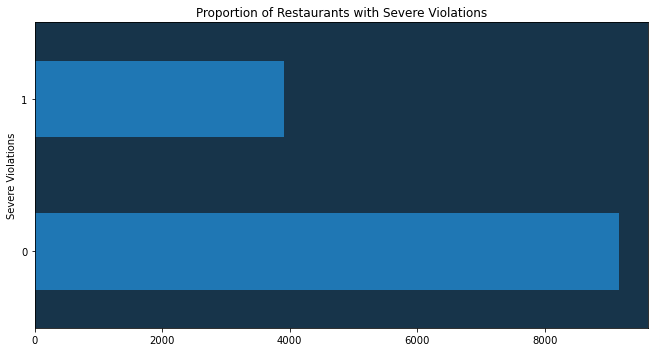

In [825]:
fig, ax = plt.subplots(figsize=(9.2, 5))

n_obs = labels_df.shape

(clean_df['Severe']
    .value_counts()
    .plot.barh(title="Proportion of Restaurants with Severe Violations", ax=ax)
)
ax.set_ylabel("Severe Violations")

fig.tight_layout()

In [826]:
counts = (eda_df[['BORO', 'Severe']]
              .groupby(['BORO', 'Severe'])
              .size()
              .unstack('Severe')
         )
counts

Severe,0,1
BORO,,
Bronx,726,345
Brooklyn,2204,999
Manhattan,4457,1869
Queens,2241,921
Staten Island,342,143


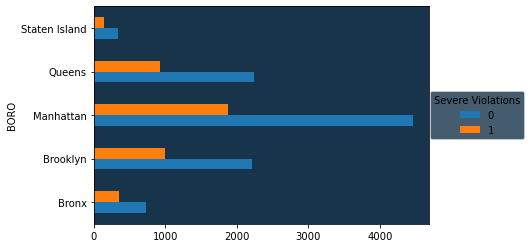

In [827]:
ax = counts.plot.barh()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='Severe Violations'
);

In [828]:
severe_counts = counts.sum(axis='columns')
severe_counts

BORO
Bronx            1071
Brooklyn         3203
Manhattan        6326
Queens           3162
Staten Island     485
dtype: int64

In [829]:
props = counts.div(severe_counts, axis='index')
props

Severe,0,1
BORO,,
Bronx,0.68,0.32
Brooklyn,0.69,0.31
Manhattan,0.70,0.30
Queens,0.71,0.29
Staten Island,0.71,0.29


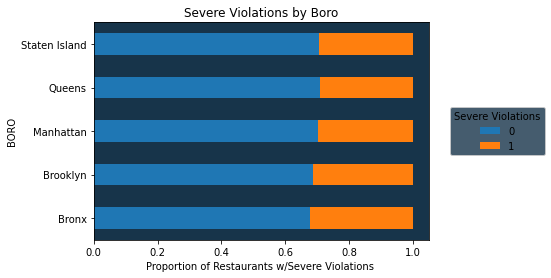

In [831]:
# Prototyping Stack Barh plot
ax = props.plot.barh(stacked=True)
ax.set_title('Severe Violations by Boro')
ax.set_xlabel('Proportion of Restaurants w/Severe Violations ')
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='Severe Violations'
);

In [839]:
def violation_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of severe health and safety violations rate against 
    each feature of the data. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (eda_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)

    ax.legend().remove()

In [833]:
eda_df.columns

Index(['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'PHONE', 'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'Severe', 'id', 'review_count', 'rating',
       'transactions', 'price', 'Reviews', 'Zip_code'],
      dtype='object')

In [840]:
# Loop through several columns and plot against both h1n1_vaccine and seasonal_vaccine.

cols_to_plot = [
    'rating',
    'transactions',
    'price'
]

fig, ax = plt.subplots(
    len(cols_to_plot), figsize=(10,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    
    violation_rate_plot(
        col, 'Severe', eda_df, ax=ax[idx]
    )
    

ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Severe Violations'
)
fig.tight_layout()

ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 720x540 with 3 Axes>

# Preprocessing For Further EDA

# Preprocessing For Modeling

In [ ]:
# OHE Dummy Variables
# Tokenizing/Vectorizing Text

In [371]:
transactions = clean_df['transactions']

In [373]:
# Use ast module to convert string objects into list
transactions = transactions.apply(lambda x: ast.literal_eval(x))

In [374]:
# Change list into dicts
dcts = transactions.apply(lambda x: {c: 1 for c in x})

# Create new dataframe based on the list of dictionaries.
ohe_df = pd.DataFrame(dcts.tolist()).fillna(0)


In [375]:
ohe_df

,delivery,pickup,restaurant_reservation
0,1.00,0.00,0.00
1,0.00,0.00,0.00
2,1.00,1.00,0.00
3,1.00,1.00,0.00
4,1.00,1.00,0.00
...,...,...,...
13056,0.00,0.00,0.00
13057,1.00,0.00,0.00
13058,0.00,0.00,1.00
13059,1.00,1.00,0.00


In [376]:
# Concatenate dummy variales with the full dataset
df_1 = pd.concat([clean_df,ohe_df],axis=1)
df_1

,index,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,review_count,rating,transactions,price,Reviews,delivery,pickup,restaurant_reservation
0,0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,55,1.50,['delivery'],$,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolut...,1.00,0.00,0.00
1,1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,55,4.50,[],NaN,I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a jo...,0.00,0.00,0.00
2,2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,54,3.00,"['pickup', 'delivery']",$$,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli ...,1.00,1.00,0.00
3,3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,49,4.50,"['pickup', 'delivery']",$,We've ordered from these folks a number of times on Grubhub and have always been extremely satis...,1.00,1.00,0.00
4,4,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,49,4.50,"['delivery', 'pickup']",$,We've ordered from these folks a number of times on Grubhub and have always been extremely satis...,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13056,18457,50113139,98K,Chicken,Brooklyn,12,BAY 25 STREET,11214.00,+17183331088,40.60,-74.00,311.00,47.00,28800.00,1,XHL1bVCv3zZskXXTiOk3Nw,137,3.50,[],$,"This is my go to dessert place since its nearby and affordable. The Ice-cream is extremely good,...",0.00,0.00,0.00
13057,18458,50113139,98K,Chicken,Brooklyn,12,BAY 25 STREET,11214.00,+17183331088,40.60,-74.00,311.00,47.00,28800.00,1,--zlzg_JqUMb3KssgmT7MA,36,3.50,['delivery'],$,My family wanted bo zai fan and decided to come try here for outdoor dining on 10/3. There was 5...,1.00,0.00,0.00
13058,18459,50113198,SENG SEAFOOD RESTAURANT,Seafood,Manhattan,39,EAST BROADWAY,10002.00,+16467999378,40.71,-74.00,103.00,1.00,800.00,0,rcwEQN8lxHzkr-QtfH_b8Q,21,4.00,['restaurant_reservation'],$$,"GREATEST PRICE FOR DIMSUM. You don't find prices like this anymore, not in NYC, not in Bay Area,...",0.00,0.00,1.00
13059,18460,50117350,SONG TEA,Coffee/Tea,Manhattan,488,7 AVENUE,10018.00,+16466697802,40.75,-73.99,105.00,3.00,10900.00,0,VAOGMSIeoou-6-Hnwsy5sw,8,4.00,"['delivery', 'pickup']",NaN,I really like the drinks here that come with mochi. It's a layer of gooey sticky ricecake that'...,1.00,1.00,0.00


In [257]:
# Joining the reviews text to a corpus
all_text = ' '.join(df.Reviews)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TfidfVectorizer object with english stop words
# and a maximum of 1500 features (to ensure that we can
# train the model in a reasonable amount of time)
vec = TfidfVectorizer(stop_words='english',
                      max_features=1500)

# create the TfIdf feature matrix from the raw text
train_tfidf = vec.fit_transform(train_text)

In [ ]:
# take a quick look at some of the features
pd.DataFrame(data=train_tfidf.todense(), columns=vec.get_feature_names()).iloc[:5, 30:45]

In [ ]:
# Unigrams

# Bigrams

# Trigrams

In [ ]:
# Word2Vect


In [ ]:
# Word embeddings

In [ ]:
# Sentiment Analysis
def review_sentiment(review):
    # Replace None with appropriate code
    if review['rating'] >= 4:
        print('positive')
    elif review['rating'] <= 2:
        print('negative')
    else:
        print('neutral')

# Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    seas_feats_df, 
    seas_labels_df, 
    test_size =.25, 
    random_state=42
)

X_train.head()

In [ ]:
from sklearn import linear_model

# get just the targets from the training labels
train_targets = train_labels[['*', '**', '***']].astype(np.float64)

# create a Linear regresion object
ols = linear_model.LinearRegression()

# fit that object on the training TfIdf matrix and target variables
ols.fit(train_tfidf, train_targets)

In [ ]:
### Function to produce the model's coefficients

def eval_clf(model, X_test_tf,y_test,cmap='Reds',
                            normalize='true',classes=['Unvaccinated', 'Vaccinated'],figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model ([type]): [description]
        X_test_tf ([type]): [description]
        y_test ([type]): [description]
        cmap (str, optional): [description]. Defaults to 'Reds'.
        normalize (str, optional): [description]. Defaults to 'true'.
        classes ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (8,4).
        X_train ([type], optional): [description]. Defaults to None.
        y_train ([type], optional): [description]. Defaults to None.
    """
    
    
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    

    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    plt.grid(False)
    plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    for a in ax:
        a.grid(False)   
        
    curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1],ls=':')
    fig.tight_layout()
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")

In [ ]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_df, y_train)

eval_clf(base,X_test_tf,y_test,X_train=X_train_df,y_train=y_train)

# Interpreting Results

In [ ]:
# get the names of the features
feature_names = np.array(vec.get_feature_names())

def get_top_features(features, model, level, limit, bottom=False):
    """ Get the top (most likely to see violations) and bottom (least
        likely to see violations) features for a given model.
        
        :param features: an array of the feature names
        :param model: a fitted linear regression model
        :param level: 0, 1, 2 for *, **, *** violation levels
        :param limit: how many features to return
        :param worst: if we want the bottom features rather than the top 
    """
    # sort order for the coefficients
    sorted_coeffs = np.argsort(model.coef_[i])
    
    if bottom:
        # get the features at the end of the sorted list
        return features[sorted_coeffs[-1 * limit:]]
    else:
        # get the features at the beginning of the sorted list
        return features[sorted_coeffs[:limit]]
    
# get the features that indicate we are most and least likely to see violations
worst_feature_sets = [get_top_features(feature_names, ols, i, 100) for i in range(3)]
best_feature_sets = [get_top_features(feature_names, ols, i, 100, bottom=True) for i in range(3)]

# reduce the independent feature sets to just the ones
# that we see in common across the per-level models (*, **, ***)
worst = reduce(np.intersect1d, best_feature_sets)
best = reduce(np.intersect1d, worst_feature_sets)

# display as a pretty table
html_fmt = "<table><th>More Violations</th><th>Fewer Violations</th><tbody>{}</tbody></table>"
table_rows = ["<tr><td>{}</td><td>{}</td></tr>".format(w, b) for w, b in zip(worst, best)]
table_body = "\n".join(table_rows)
display.HTML(html_fmt.format(table_body))

# Conclusions

## Best Model Results

## Takeaways and Recommended Actions

##  Next Steps and Future Work